Importing Libraries


In [2]:
import os
import random
import numpy as np
import timm

import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")
# random.seed(42)

Load dataset


In [3]:
# Define the path to the main data directory
# drive.mount('/content/drive')
# data_dir = '/content/drive/My Drive/Waste_classification/data'

data_dir = 'data'

is_normalization = True

transform_list = [
    transforms.Resize((512, 512)),
    transforms.ToTensor()
]

if is_normalization:
    transform_list.append(transforms.Normalize(
        mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))


transform = transforms.Compose(transform_list)

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(f"Number of samples: {len(full_dataset)}")

class_names = full_dataset.classes
print(class_names)

Number of samples: 2527
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Count each class


In [ ]:
class_count = {}
for _, label in full_dataset:
    class_count[label] = class_count.get(label, 0) + 1

for i, name in enumerate(class_names):
    print(f"{name}: {class_count[i]}")

cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


View random images


Image index: 2071 || Label: 4 || Class: plastic


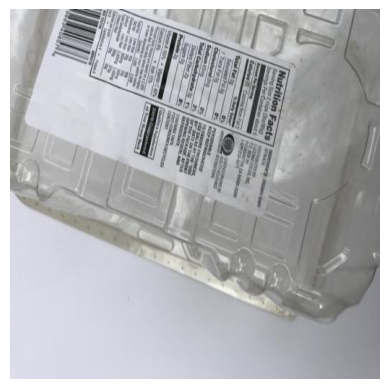

In [ ]:
import random
import matplotlib.pyplot as plt

num_images = 1

for i in range(num_images):

    rand_idx = random.randint(0, len(full_dataset) - 1)
    image, label = full_dataset[rand_idx]

    # Denormalize the image
    if is_normalization:
        image = image * 0.5 + 0.5

    print(
        f'Image index: {rand_idx} || Label: {label} || Class: {class_names[label]}')

    # Convert from (C, H, W) to (H, W, C) for visualization
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

Train test split & Create Dataloader


In [ ]:
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size


train_dataset, test_dataset = random_split(
    full_dataset, [train_size, test_size])


batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=False)


def check_data_loaders(loader):
    for images, labels in loader:
        print(f'Batch of images shape: {images.size()}')
        print(f'Batch of labels shape: {labels.size()}')
        break


print("Training data:")
check_data_loaders(train_loader)


print("\nTest data:")
check_data_loaders(test_loader)

Training data:
Batch of images shape: torch.Size([64, 3, 512, 512])
Batch of labels shape: torch.Size([64])

Test data:
Batch of images shape: torch.Size([64, 3, 512, 512])
Batch of labels shape: torch.Size([64])


Define CNN class


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


num_classes = len(class_names)
model = SimpleCNN(num_classes)

Define Training fun


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)


def train(model, criterion, optimizer, train_loader, num_epochs=5):
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for images, labels in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                tepoch.set_postfix(loss=running_loss/len(tepoch))

        loss_history.append(running_loss/len(train_loader))
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return loss_history

Define eval fun


In [116]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.2f}')

Training and evaluation


Epoch 10/10: 100%|██████████| 32/32 [06:42<00:00, 12.59s/batch, loss=0.528]


Accuracy: 0.72


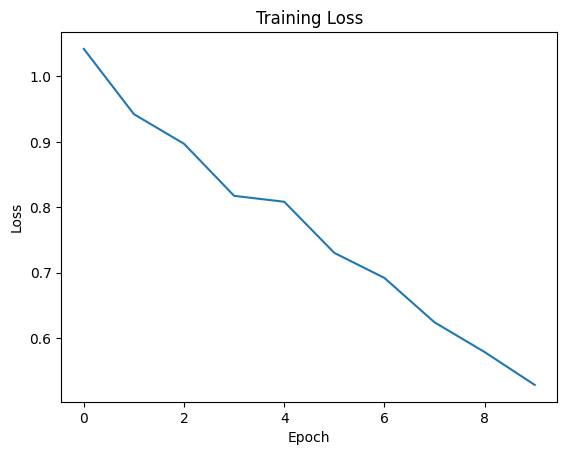

In [ ]:
# Train the model
loss_history = train(model, criterion, optimizer, train_loader, num_epochs=10)

# Evaluate the model
evaluate_model(model, test_loader)

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Check random prediction


Predicted: metal, Actual: metal


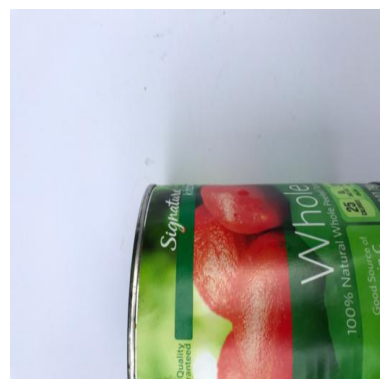

In [ ]:
def predict_image(model, image, is_normalization):

    model.eval()

    transformation = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    if is_normalization:
        transformation.transforms.append(transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))

    image = transformation(image).float()

    # Add an extra batch dimension since PyTorch treats all images as batches
    image = image.unsqueeze(0)

    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output.data, 1)

    return class_names[predicted.item()]


random_image = random.choice(test_dataset)
image, label = random_image

# Convert the image tensor to a PIL image for visualization
image_pil = transforms.ToPILImage()(image)

predicted_label = predict_image(model, image_pil, is_normalization)
print(f'Predicted: {predicted_label}, Actual: {class_names[label]}')

# Denormalize and clamp the image for display
image_display = torch.clamp(image * 0.5 + 0.5, 0, 1)

# Display the image
plt.imshow(image_display.permute(1, 2, 0))
plt.axis('off')
plt.show()

Save the model


In [ ]:
# save the model
# torch.save(model.state_dict(), 'model_72.pth')
# print("Model saved")

Model saved


Different Matrix


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_model_(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.2f}')

    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix:\n{cm}')

    cr = classification_report(y_true, y_pred, target_names=class_names)
    print(f'Classification Report:\n{cr}')


# Evaluate the model
evaluate_model_(model, test_loader)

Accuracy: 0.72
Confusion Matrix:
[[54  5  0  9  1  1]
 [ 3 75  4  6 11  1]
 [ 3  7 61 18  4  1]
 [ 3  4  4 87  2  1]
 [ 7 16  4  7 78  2]
 [ 2  9  3  3  2  8]]
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.75      0.77      0.76        70
       glass       0.65      0.75      0.69       100
       metal       0.80      0.65      0.72        94
       paper       0.67      0.86      0.75       101
     plastic       0.80      0.68      0.74       114
       trash       0.57      0.30      0.39        27

    accuracy                           0.72       506
   macro avg       0.71      0.67      0.68       506
weighted avg       0.72      0.72      0.71       506

